In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

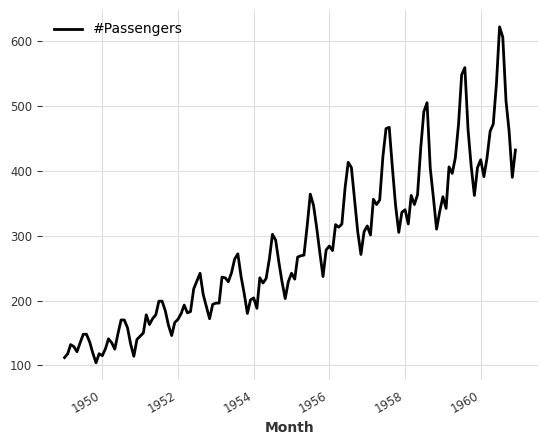

In [2]:
series = AirPassengersDataset().load()
series.plot()

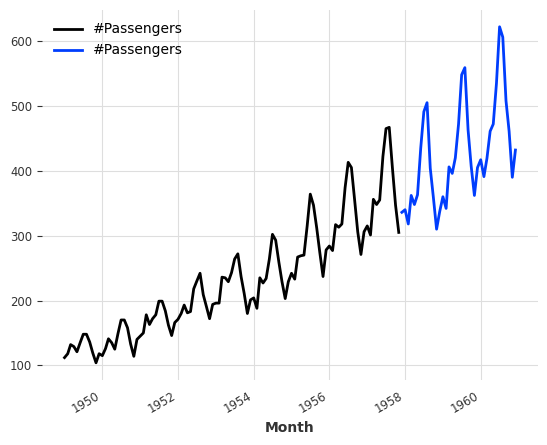

In [3]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

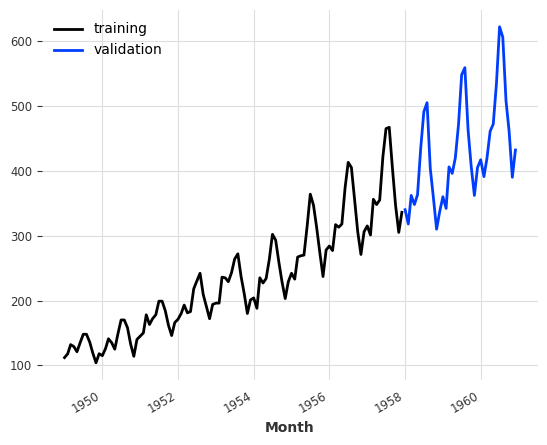

In [4]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

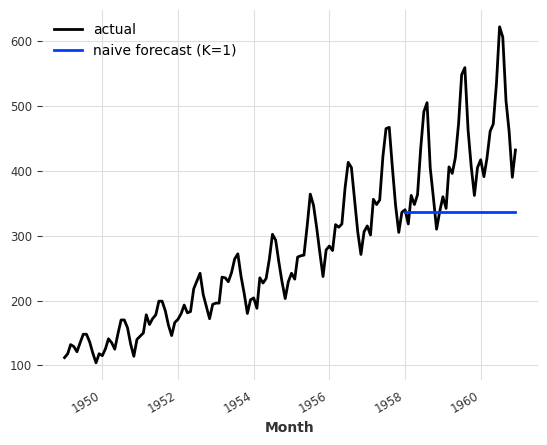

In [5]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

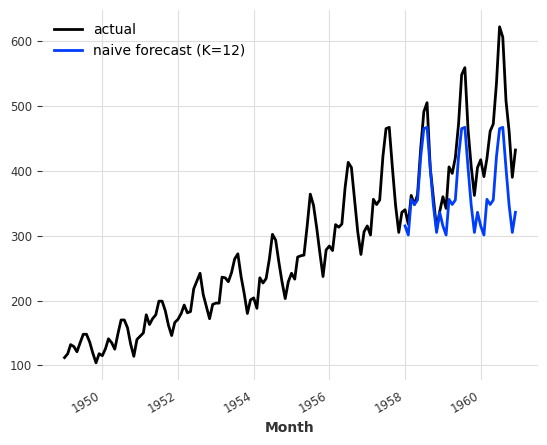

In [6]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

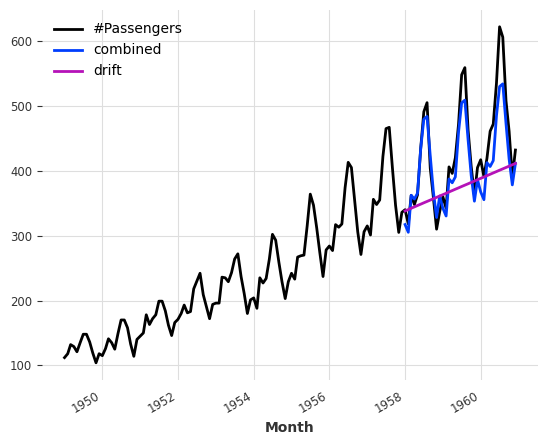

In [7]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [9]:

# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [10]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [16]:

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "mps",
        "devices": 1,
    },
)

In [17]:
#print environment variable PYTORCH_ENABLE_MPS_FALLBACK
import os

#set PYTORCH_ENABLE_MPS_FALLBACK = 1
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [18]:

print(os.environ.get('PYTORCH_ENABLE_MPS_FALLBACK'))

1


In [19]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: 0it [00:00, ?it/s]

NotImplementedError: The operator 'aten::upsample_linear1d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [31]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

Predicting: 5it [00:00, ?it/s]

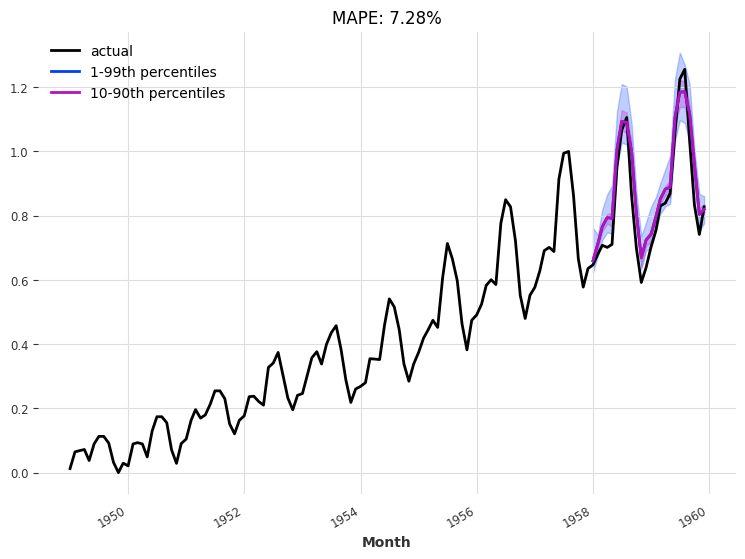

In [32]:
eval_model(my_model, 24, series_transformed, val_transformed)

## TEST MPS

In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.datasets import AirPassengersDataset

In [39]:
# Read data:
series = AirPassengersDataset().load()
series = series.astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [40]:
my_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
        "precision": 32
    },
)

In [ ]:
my_model.fit(train_transformed, val_series=val_transformed)

In [45]:
pred_series = my_model.predict(24)

Predicting: 7it [00:00, ?it/s]

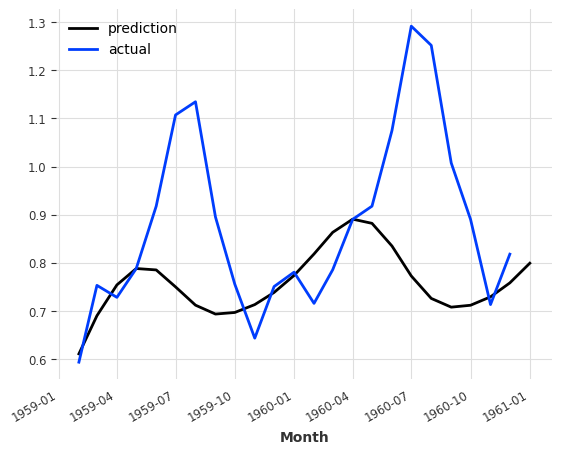

In [47]:
pred_series.plot(label='prediction')
val_transformed.plot(label='actual')